# **Header with Contributors**

**A Data-Driven Approach to Formula One Race Outcome Prediction**  
**Spring 2025 Data Science Project**  
**Sathya Selvam, Daniel Valencia, Aidan Buergin, Qiyu An**

**Contributions**:   

**Project idea**: Sathya Selvam, Daniel Valencia, Aidan Buergin, Qiyu An - Everyone contributed to brainstorming our end goal and our methods for approaching each checkpoint.  
**Dataset Curation and Preprocessing**: Sathya Selvam, Daniel Valencia - Sathya and Daniel took iniative and found datasets online. They completed the majority of initial data preprocessing, such as translating csv files to DataFrames.  
**Data Exploration and Summary Statistics**: Sathya Selvam, Daniel Valencia, Qiyu An, Aidan Buergin - Sathya, Daniel, And Qiyu wrote the code for our checkpoint 2 data exploration. Aidan Buergin wrote the summaries of the findings for each observation.  
**ML Algorithm Design/Development**: Aidan Buergin, Daniel Valencia, Sathya Selvam - These team members completed the data preprocessing for the models and decided on the specific models to be used.    
**ML Algorithm Training and Test Data Analysis**: Aidan Buergin, Daniel Valencia, Sathya Selvam - These members calculated MAE and R2 score for each model, then created graphs to compare these values.   
**Visualization, Result Analysis, Conclusion**: Qiyu An, Aidan Buergin, Daniel Valencia, Sathya Selvam - Aidan, Daniel, and Sathya created graphs and compared results between models. Qiyu wrote the result analysis and conclusion to the project.  
**Final Tutorial Report Creation**: Qiyu An - Wrote the Introduction, Conclusion, Next Steps, and most of the wording between blocks of code to finish the project.  


# **Introduction**

Formula 1 is one of the most advanced and fast-paced motorsports in the world, combining driver skill, engineering, and strategy. Each race produces a large amount of data, including qualifying times, pit stop durations, and final race positions. With so many variables influencing the outcome, we were interested in exploring whether machine learning could help us predict the finishing positions of drivers based on pre-race information.

In this project, our goal is to compare different supervised regression models to see how accurately they can predict a driver's final position in a race. Some of the features we consider include qualifying position, constructor (team), and other race-related information. We test a variety of models, from linear regression to more advanced techniques like random forests and gradient-boosted trees.

Throughout this tutorial, we follow the full data science process: from cleaning and organizing the data, to training models and analyzing results. By the end, we hope to identify which regression approach gives us the most accurate predictions and gain insights into which features most strongly influence race outcomes.

In our data, we have 14 .csv files, all with unique categories from which we can draw different conclusions. Some of these files include driver information, team/constructor information, circuits, pit stop information, and qualifying information. Almost all .csv files share a column called “driverId” and a column called “raceId”. These categories being shared among the files allow us to utilize separate .csv files for analyses, linking together rows in separate files with the same driverId or raceId value. Another intriguing feature of the data is that some of the rows have NA values for certain categories. These especially include time in milliseconds for datasets like pit stop times and race finish times. For past races in which they did not have the technology to record this information, the columns remain as NA.

# **Environment Setup and Data Loading**


First import the data set and do a really simple reformatting across it to replace \N with pd.NA.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/final_project_320

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/final_project_320


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as mtpl
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

circ = pd.read_csv('data_bases/circuits.csv')
constr_re = pd.read_csv('data_bases/constructor_results.csv')
constr_std = pd.read_csv('data_bases/constructor_standings.csv')
constr = pd.read_csv('data_bases/constructors.csv')
driver = pd.read_csv('data_bases/drivers.csv')
driver_std = pd.read_csv('data_bases/driver_standings.csv')
lap_times = pd.read_csv('data_bases/lap_times.csv')
pit_stops = pd.read_csv('data_bases/pit_stops.csv')
qualifying = pd.read_csv('data_bases/qualifying.csv')
races = pd.read_csv('data_bases/races.csv')
results = pd.read_csv('data_bases/results.csv')
sprint_results = pd.read_csv('data_bases/sprint_results.csv')
status = pd.read_csv('data_bases/status.csv')

# **Preliminary Data Analysis and Insights**

## 1. Correlation between Qualifying 1st and Finishing 1st

For the first conclusion about our data, we have decided to use a Chi-Square test to determine statistical significance between driver who finish first in qualifying for a race, and the drivers who win the race.

Null Hypothesis: There is no correlation between drivers finishing first im qualifying and finishing first in the following race.

Alternative Hypothesis: There is a correlation between drivers finishing first in qualifying and finishing first in the following race.

Alpha: .05

In [ ]:
import pandas as pd
from scipy.stats.contingency import crosstab, chi2_contingency

pole = qualifying[qualifying['position'] == 1][['raceId', 'driverId']]
pole = pole.rename(columns={'driverId': 'pole_driver'})

winners = results[results['position'] == '1'][['raceId', 'driverId']]
winners = winners.rename(columns={'driverId': 'race_winner'})

merged = pd.merge(pole, winners, on='raceId', how='inner')
merged = merged[merged['raceId'] >= 900]
print(merged)

table = crosstab(merged['pole_driver'], merged['race_winner'])
contingency_table = table.count
res = chi2_contingency(contingency_table)
print("P-value: ", res.pvalue)

     raceId  pole_driver  race_winner
265     900            1            3
266     901            1            1
267     902            3            1
269     903            1            1
270     904            1            1
..      ...          ...          ...
489    1140          832          832
490    1141          846          830
491    1142          847          847
492    1143          830          830
493    1144          846          846

[228 rows x 3 columns]
P-value:  1.640386297964361e-42


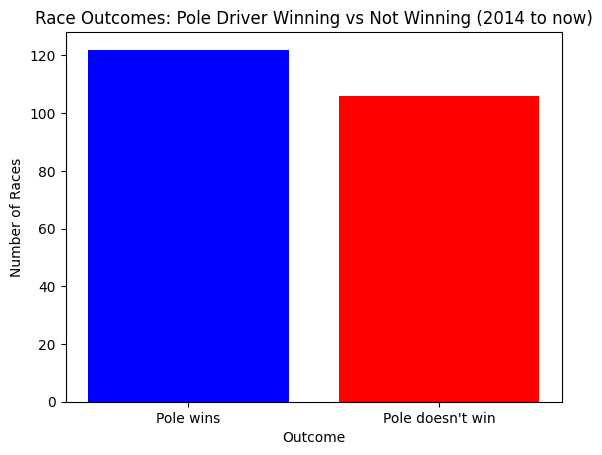

In [ ]:
merged['pole_win'] = merged['pole_driver'] == merged['race_winner']
counts = merged['pole_win'].replace({True: "Pole wins", False: "Pole doesn't win"}).value_counts()

mtpl.bar(counts.index, counts, color=['blue', 'red'])
mtpl.title("Race Outcomes: Pole Driver Winning vs Not Winning (2014 to now)")
mtpl.xlabel("Outcome")
mtpl.ylabel("Number of Races")
mtpl.show()

After completing a Chi-Square test and graphing the data, we find a P-value of 1.64e-42, an extremely small number. This indicates that there is a very statistically significant correlation between the drivers finishing first in the qualifying rounds and winning the race afterwards. With this, we reject the null hypothesis that there is no correlation between these categories of data. This result comes as no surpirse for fans of Formula 1. The qualifying stage is extremely important for the actual race which usually comes the next day. This stage determines what position the drivers will begin the race in.

##2. Pit stop durations - Identifying outliers

In our second conclusion, we look to determine if there are any outliers in the pit stop durations dataset.

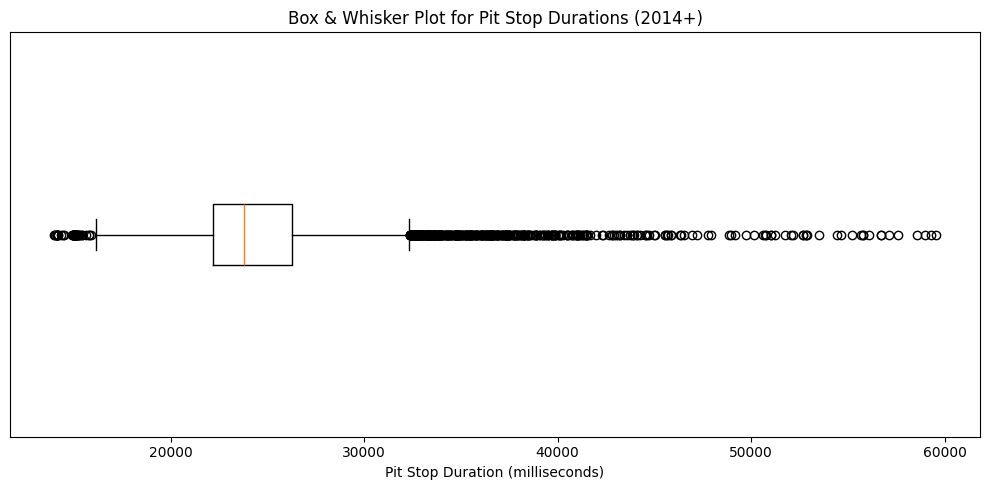

Median pit stop duration (milliseconds): 23792.0


In [ ]:
# 2nd statistical methods: Are there any unusually long pit stop durations(outlier) in Formula 1 races from 2014 onwards?
# Answer: Yes, there are many long pit stops that clearly stand out as outliers in the data.
# These extreme values could be caused by technical issues, penalties, or even data errors, and should be analyzed separately from typical pit stop behavior.

# Dataset used: pit_stops.csv (which includes: raceId, driverId, stop, lap, time, duration, milliseconds)


# Merge pit stop data with race info to get the year
pit_merged = pd.merge(pit_stops, races[['raceId', 'year']], on='raceId')


# Filter for races from 2014 onward
pit_filtered = pit_merged[pit_merged['year'] >= 2014].copy()


# Remove bad durations with ":" like 16:37.029, those extreme and unusual long pitstop time
pit_filtered = pit_filtered[pit_filtered['duration'].str.contains(":") == False]


# Drop missing values
pit_filtered = pit_filtered.dropna(subset=['milliseconds'])


mtpl.figure(figsize=(10, 5))
mtpl.boxplot(pit_filtered['milliseconds'], vert=False)
mtpl.title("Box & Whisker Plot for Pit Stop Durations (2014+)")
mtpl.xlabel("Pit Stop Duration (milliseconds)")
mtpl.yticks([]) # Remove the '1' in default y-axis
mtpl.ticklabel_format(style='plain', axis='x') # Disables scientific notation
mtpl.tight_layout()
mtpl.show()


print("Median pit stop duration (milliseconds):", pit_filtered['milliseconds'].median())


With the resulting Box-and-Whisker plot, we observe that there are a large sum of outliers beyond the first standard deviation. A small few of these outliers almost reach 60000 milliseconds, which is roughly three times the median of 23792 milliseconds, or 23.8 seconds. There are also outliers that fall much shorter than the average pit stop time, reaching close to 10000 milliseconds, or 10 seconds.

## 3. Identifying Top Constructors since 2000

Our third and last statistical conclusion will be to identify the top teams/constructors over the last 25 years in Formula 1. By graphing all active teams from the years 2000-onward and their total points accumulated since then, we should be able to see which teams are the strongest in the Formula 1 space.

In [ ]:
teams = constr.merge(results, on='constructorId')
teams = teams.merge(races, on='raceId')

# Rename the merged result
teams_simple = teams[['name_x', 'points', 'year']]
teams_simple = teams_simple.rename(columns={'name_x':'name'})
teams_simple

# Just get the top teams that have more than 50 points
top_teams = teams_simple[teams_simple['year'] > 2000].groupby('name').agg({'points':'sum'}).sort_values('points',ascending=False).reset_index()
top_teams = top_teams[top_teams['points'] >= 50]
display(top_teams)

name  points
0         Red Bull  7673.0
1          Ferrari  7661.5
2         Mercedes  7591.5
3          McLaren  4583.0
4         Williams  1609.5
5          Renault  1465.0
6      Force India  1098.0
7         Lotus F1   706.0
8       Toro Rosso   500.0
9   Alpine F1 Team   498.0
10    Aston Martin   492.0
11          Sauber   471.0
12      BMW Sauber   308.0
13      AlphaTauri   306.0
14    Haas F1 Team   293.0
15    Racing Point   283.0
16          Toyota   278.5
17             BAR   207.0
18           Brawn   172.0
19      Alfa Romeo   147.0
20           Honda   106.0
21          Jordan    58.0

<BarContainer object of 22 artists>

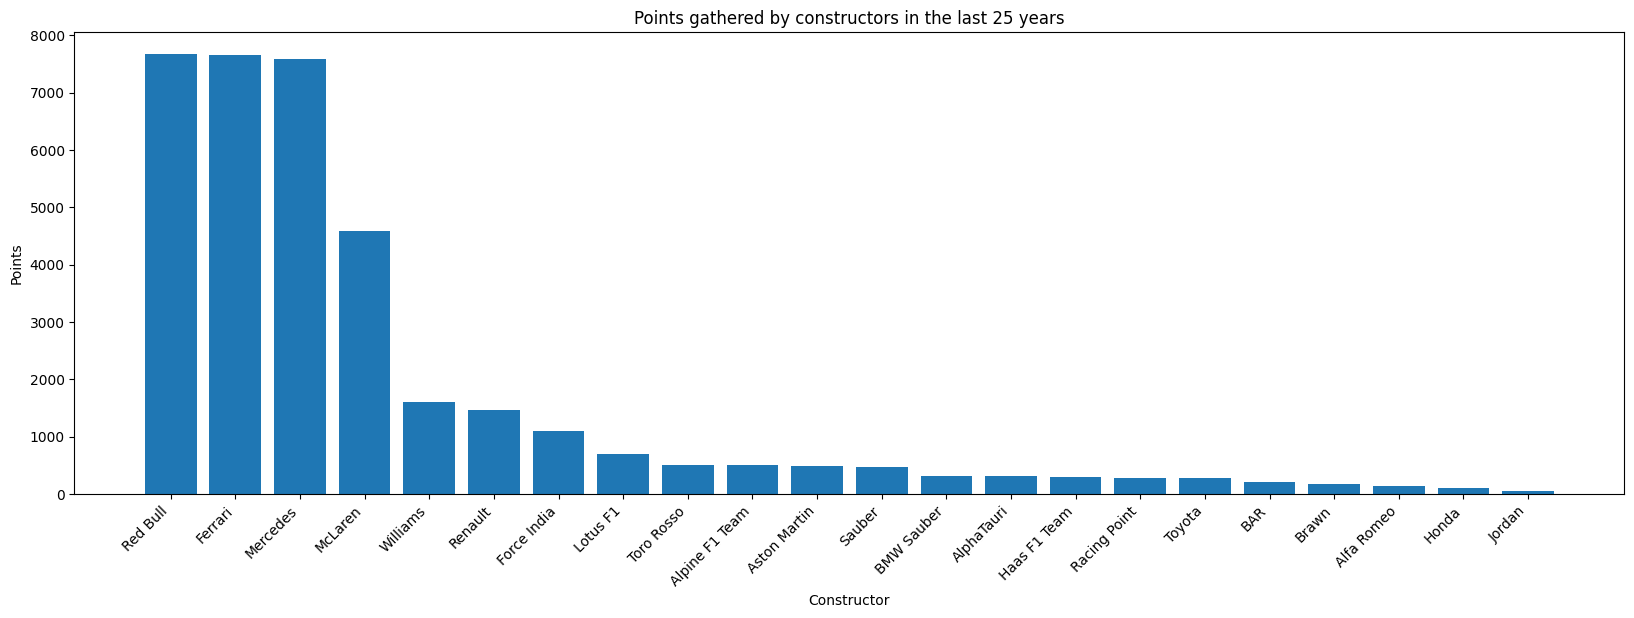

In [ ]:
mtpl.figure(figsize=(20,6))
mtpl.xticks(rotation=45, ha='right')
mtpl.xlabel('Constructor')
mtpl.ylabel('Points')
mtpl.title('Points gathered by constructors in the last 25 years')
mtpl.bar(top_teams['name'], top_teams['points'])

As we can see, there are very large differences in total points earned between the first four performing teams and every other team in recent history. Red Bull, Ferrari, Mercedes, and McLaren appear to dominate the rest of their competition in the Formula 1 space. For fans of Forumla 1, this comes as no surprise. This graph goes to show what some might call the monopoly that the powerful few top constructors have in the Formula 1 series.

#**Feature Engineering: Race Count and Recent Performance**

In this next section, we prepare our dataset for machine learning by engineering new features that may help improve prediction accuracy. Specifically, we focus on creating two new columns: the number of past races a driver has completed (*race_count*) and their recent performance based on their average finishing position in the last five races (*avg_last5_finish*).

We started by merging the race results with race dates so we could organize everything in order by driver and time. Then, for each driver, we counted how many races they had done before the current one using a cumulative count. For recent performance, we used a rolling average of their last five finish positions, ignoring the current race. If a driver didn’t have five previous races, we still gave them an average using however many were available, and filled in any missing values with a default of 10.

Lastly, we filtered the data to only include races after 2018 so our analysis stays focused on more recent seasons.

The output is a refined dataframe that includes not only existing race result features but also cumulative race experience and recent performance trends for each driver, which are two factors that can potentially enhance our predictive models.

In [ ]:
# Merge with race date
merged_df = results.merge(races[['raceId', 'date']], on='raceId')
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Sort by driver and date for cumulative calculations
merged_df = merged_df.sort_values(by=['driverId', 'date'])

# Calculate race count (number of races before current race)
merged_df['race_count'] = merged_df.groupby('driverId').cumcount()

# Calculate historical average finish in last 5 races (excluding current race)
merged_df['avg_last5_finish'] = (
    merged_df.groupby('driverId')['positionOrder']
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
)

merged_df['avg_last5_finish'] = merged_df['avg_last5_finish'].fillna(10)

# Filter data to races after 2018
merged_df = merged_df[merged_df['date'] > '2018']

merged_df

resultId  raceId  driverId  constructorId number  grid position  \
23778     23783     989         1            131     44     1        2   
23799     23804     990         1            131     44     9        3   
23820     23825     991         1            131     44     4        4   
23837     23842     992         1            131     44     2        1   
23857     23862     993         1            131     44     1        1   
...         ...     ...       ...            ...    ...   ...      ...   
26695     26701    1141       861              3     43    16       \N   
26712     26718    1142       861              3     43     0       14   
26737     26743    1143       861              3     43    19       \N   
26757     26763    1144       861              3     43    20       \N   
26753     26759    1144       862            214     61    17       15   

      positionText  positionOrder  points  ...         time milliseconds  \
23778            2              2    18.0  ...       +5.036      5378319   
23799            3              3    15.0  ...       +6.512      5528452   
23820            4              4    12.0  ...      +16.985      5753365   
23837            1              1    25.0  ...  1:43:44.291      6224291   
23857            1              1    25.0  ...  1:35:29.972      5729972   
...            ...            ...     ...  ...          ...          ...   
26695            R             17     0.0  ...           \N           \N   
26712           14             14     0.0  ...    +1:15.172      5001141   
26737            R             19     0.0  ...           \N           \N   
26757            R             19     0.0  ...           \N           \N   
26753           15             15     0.0  ...           \N           \N   

      fastestLap rank fastestLapTime fastestLapSpeed statusId       date  \
23778         50    3       1:26.444         220.845        1 2018-03-25   
23799         51    2       1:33.953         207.371        1 2018-04-08   
23820         20    4       1:36.878         202.559        1 2018-04-15   
23837         35    2       1:45.412         205.012        1 2018-04-29   
23857         64    3       1:19.133         211.770        1 2018-05-13   
...          ...  ...            ...             ...      ...        ...   
26695         21   18       1:24.296         184.022        3 2024-11-03   
26712         37   15       1:36.867         230.456        1 2024-11-23   
26737         \N    0             \N              \N        4 2024-12-01   
26757          5   17       1:29.411         212.631        5 2024-12-08   
26753         56   13       1:29.121         213.323       11 2024-12-08   

      race_count  avg_last5_finish  
23778        208               3.4  
23799        209               3.6  
23820        210               4.0  
23837        211               3.0  
23857        212               2.4  
...          ...               ...  
26695          5              10.6  
26712          6              11.6  
26737          7              12.8  
26757          8              14.4  
26753          0              10.0  

[2979 rows x 21 columns]

To prepare our data for modeling, we first need to gather all relevant information about each race, driver, and team, and then transform it into a clean format suitable for machine learning. This section walks through the full process of merging multiple datasets—including race results, driver and team details, and qualifying positions—to create one comprehensive table. From this combined dataset, we select key features like starting position, recent race performance, driver and team names, and the track name. These features are then separated into input variables (X) and target output (Y) for our models. We also set up a preprocessing pipeline that encodes categorical variables and scales numerical ones, ensuring our data is properly formatted. Finally, we split the dataset into training and testing sets so we can evaluate the performance of different regression models in a fair and consistent way.

In [ ]:
#do merges to get table of inputs for fitting together

inputs = merged_df[['raceId', 'constructorId', 'driverId', 'positionOrder', 'race_count', 'avg_last5_finish']]
display(inputs)

#merge on raceId to include circuit name
circuits_merged = pd.merge(inputs, races, on='raceId', how='inner')
circuits_merged['circName'] = circuits_merged['name']
circuits_merged = circuits_merged[['raceId', 'constructorId', 'driverId', 'positionOrder', 'race_count', 'avg_last5_finish', 'circName']]
display(circuits_merged)

#merge on driverId to include driver name
drivers_merged = pd.merge(circuits_merged, driver, on='driverId', how='inner')
drivers_merged['driverName'] = drivers_merged['forename'] + " " + drivers_merged['surname'] #combine first and last name into one
drivers_merged = drivers_merged[['raceId', 'constructorId', 'driverId', 'positionOrder', 'race_count', 'avg_last5_finish', 'circName', 'driverName']]
display(drivers_merged)

#merge on constructorId to include team name
constructors_merged = pd.merge(drivers_merged, constr, on='constructorId', how='inner')
constructors_merged['teamName'] = constructors_merged['name']
constructors_merged = constructors_merged[['raceId', 'constructorId', 'driverId', 'positionOrder', 'race_count', 'avg_last5_finish', 'circName', 'driverName', 'teamName']]
display(constructors_merged)

#merge on all Ids to include starting postion for the race
qualifying_merged = pd.merge(constructors_merged, qualifying, on=['raceId', 'driverId', 'constructorId'], how='inner')
qualifying_merged['startingPosition'] = qualifying_merged['position']
qualifying_merged = qualifying_merged[['raceId', 'constructorId', 'driverId', 'positionOrder', 'race_count', 'avg_last5_finish', 'circName', 'driverName', 'teamName', 'startingPosition']]
qualifying_merged['finishingPosition'] = qualifying_merged['positionOrder']
display(qualifying_merged)

#filter out the Ids that were only used for the merges
inputs = qualifying_merged[['race_count', 'avg_last5_finish', 'circName', 'driverName', 'teamName', 'startingPosition', 'finishingPosition']]
display(inputs)

categorical_cols = ['circName', 'driverName', 'teamName']
numeric_cols = ['race_count', 'avg_last5_finish', 'startingPosition']

# Preprocessor for encoding
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

#separate X and Y, then split test and train
X = inputs[['race_count', 'avg_last5_finish', 'circName', 'driverName', 'teamName', 'startingPosition']]
Y = inputs[['finishingPosition']]
display(X)
display(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

display(X_train)

raceId  constructorId  driverId  positionOrder  race_count  \
23778     989            131         1              2         208   
23799     990            131         1              3         209   
23820     991            131         1              4         210   
23837     992            131         1              1         211   
23857     993            131         1              1         212   
...       ...            ...       ...            ...         ...   
26695    1141              3       861             17           5   
26712    1142              3       861             14           6   
26737    1143              3       861             19           7   
26757    1144              3       861             19           8   
26753    1144            214       862             15           0   

       avg_last5_finish  
23778               3.4  
23799               3.6  
23820               4.0  
23837               3.0  
23857               2.4  
...                 ...  
26695              10.6  
26712              11.6  
26737              12.8  
26757              14.4  
26753              10.0  

[2979 rows x 6 columns]

raceId  constructorId  driverId  positionOrder  race_count  \
0        989            131         1              2         208   
1        990            131         1              3         209   
2        991            131         1              4         210   
3        992            131         1              1         211   
4        993            131         1              1         212   
...      ...            ...       ...            ...         ...   
2974    1141              3       861             17           5   
2975    1142              3       861             14           6   
2976    1143              3       861             19           7   
2977    1144              3       861             19           8   
2978    1144            214       862             15           0   

      avg_last5_finish               circName  
0                  3.4  Australian Grand Prix  
1                  3.6     Bahrain Grand Prix  
2                  4.0     Chinese Grand Prix  
3                  3.0  Azerbaijan Grand Prix  
4                  2.4     Spanish Grand Prix  
...                ...                    ...  
2974              10.6   São Paulo Grand Prix  
2975              11.6   Las Vegas Grand Prix  
2976              12.8       Qatar Grand Prix  
2977              14.4   Abu Dhabi Grand Prix  
2978              10.0   Abu Dhabi Grand Prix  

[2979 rows x 7 columns]

raceId  constructorId  driverId  positionOrder  race_count  \
0        989            131         1              2         208   
1        990            131         1              3         209   
2        991            131         1              4         210   
3        992            131         1              1         211   
4        993            131         1              1         212   
...      ...            ...       ...            ...         ...   
2974    1141              3       861             17           5   
2975    1142              3       861             14           6   
2976    1143              3       861             19           7   
2977    1144              3       861             19           8   
2978    1144            214       862             15           0   

      avg_last5_finish               circName        driverName  
0                  3.4  Australian Grand Prix    Lewis Hamilton  
1                  3.6     Bahrain Grand Prix    Lewis Hamilton  
2                  4.0     Chinese Grand Prix    Lewis Hamilton  
3                  3.0  Azerbaijan Grand Prix    Lewis Hamilton  
4                  2.4     Spanish Grand Prix    Lewis Hamilton  
...                ...                    ...               ...  
2974              10.6   São Paulo Grand Prix  Franco Colapinto  
2975              11.6   Las Vegas Grand Prix  Franco Colapinto  
2976              12.8       Qatar Grand Prix  Franco Colapinto  
2977              14.4   Abu Dhabi Grand Prix  Franco Colapinto  
2978              10.0   Abu Dhabi Grand Prix       Jack Doohan  

[2979 rows x 8 columns]

raceId  constructorId  driverId  positionOrder  race_count  \
0        989            131         1              2         208   
1        990            131         1              3         209   
2        991            131         1              4         210   
3        992            131         1              1         211   
4        993            131         1              1         212   
...      ...            ...       ...            ...         ...   
2974    1141              3       861             17           5   
2975    1142              3       861             14           6   
2976    1143              3       861             19           7   
2977    1144              3       861             19           8   
2978    1144            214       862             15           0   

      avg_last5_finish               circName        driverName  \
0                  3.4  Australian Grand Prix    Lewis Hamilton   
1                  3.6     Bahrain Grand Prix    Lewis Hamilton   
2                  4.0     Chinese Grand Prix    Lewis Hamilton   
3                  3.0  Azerbaijan Grand Prix    Lewis Hamilton   
4                  2.4     Spanish Grand Prix    Lewis Hamilton   
...                ...                    ...               ...   
2974              10.6   São Paulo Grand Prix  Franco Colapinto   
2975              11.6   Las Vegas Grand Prix  Franco Colapinto   
2976              12.8       Qatar Grand Prix  Franco Colapinto   
2977              14.4   Abu Dhabi Grand Prix  Franco Colapinto   
2978              10.0   Abu Dhabi Grand Prix       Jack Doohan   

            teamName  
0           Mercedes  
1           Mercedes  
2           Mercedes  
3           Mercedes  
4           Mercedes  
...              ...  
2974        Williams  
2975        Williams  
2976        Williams  
2977        Williams  
2978  Alpine F1 Team  

[2979 rows x 9 columns]

raceId  constructorId  driverId  positionOrder  race_count  \
0        989            131         1              2         208   
1        990            131         1              3         209   
2        991            131         1              4         210   
3        992            131         1              1         211   
4        993            131         1              1         212   
...      ...            ...       ...            ...         ...   
2971    1141              3       861             17           5   
2972    1142              3       861             14           6   
2973    1143              3       861             19           7   
2974    1144              3       861             19           8   
2975    1144            214       862             15           0   

      avg_last5_finish               circName        driverName  \
0                  3.4  Australian Grand Prix    Lewis Hamilton   
1                  3.6     Bahrain Grand Prix    Lewis Hamilton   
2                  4.0     Chinese Grand Prix    Lewis Hamilton   
3                  3.0  Azerbaijan Grand Prix    Lewis Hamilton   
4                  2.4     Spanish Grand Prix    Lewis Hamilton   
...                ...                    ...               ...   
2971              10.6   São Paulo Grand Prix  Franco Colapinto   
2972              11.6   Las Vegas Grand Prix  Franco Colapinto   
2973              12.8       Qatar Grand Prix  Franco Colapinto   
2974              14.4   Abu Dhabi Grand Prix  Franco Colapinto   
2975              10.0   Abu Dhabi Grand Prix       Jack Doohan   

            teamName  startingPosition  finishingPosition  
0           Mercedes                 1                  2  
1           Mercedes                 4                  3  
2           Mercedes                 4                  4  
3           Mercedes                 2                  1  
4           Mercedes                 1                  1  
...              ...               ...                ...  
2971        Williams                18                 17  
2972        Williams                14                 14  
2973        Williams                19                 19  
2974        Williams                19                 19  
2975  Alpine F1 Team                20                 15  

[2976 rows x 11 columns]

race_count  avg_last5_finish               circName        driverName  \
0            208               3.4  Australian Grand Prix    Lewis Hamilton   
1            209               3.6     Bahrain Grand Prix    Lewis Hamilton   
2            210               4.0     Chinese Grand Prix    Lewis Hamilton   
3            211               3.0  Azerbaijan Grand Prix    Lewis Hamilton   
4            212               2.4     Spanish Grand Prix    Lewis Hamilton   
...          ...               ...                    ...               ...   
2971           5              10.6   São Paulo Grand Prix  Franco Colapinto   
2972           6              11.6   Las Vegas Grand Prix  Franco Colapinto   
2973           7              12.8       Qatar Grand Prix  Franco Colapinto   
2974           8              14.4   Abu Dhabi Grand Prix  Franco Colapinto   
2975           0              10.0   Abu Dhabi Grand Prix       Jack Doohan   

            teamName  startingPosition  finishingPosition  
0           Mercedes                 1                  2  
1           Mercedes                 4                  3  
2           Mercedes                 4                  4  
3           Mercedes                 2                  1  
4           Mercedes                 1                  1  
...              ...               ...                ...  
2971        Williams                18                 17  
2972        Williams                14                 14  
2973        Williams                19                 19  
2974        Williams                19                 19  
2975  Alpine F1 Team                20                 15  

[2976 rows x 7 columns]

race_count  avg_last5_finish               circName        driverName  \
0            208               3.4  Australian Grand Prix    Lewis Hamilton   
1            209               3.6     Bahrain Grand Prix    Lewis Hamilton   
2            210               4.0     Chinese Grand Prix    Lewis Hamilton   
3            211               3.0  Azerbaijan Grand Prix    Lewis Hamilton   
4            212               2.4     Spanish Grand Prix    Lewis Hamilton   
...          ...               ...                    ...               ...   
2971           5              10.6   São Paulo Grand Prix  Franco Colapinto   
2972           6              11.6   Las Vegas Grand Prix  Franco Colapinto   
2973           7              12.8       Qatar Grand Prix  Franco Colapinto   
2974           8              14.4   Abu Dhabi Grand Prix  Franco Colapinto   
2975           0              10.0   Abu Dhabi Grand Prix       Jack Doohan   

            teamName  startingPosition  
0           Mercedes                 1  
1           Mercedes                 4  
2           Mercedes                 4  
3           Mercedes                 2  
4           Mercedes                 1  
...              ...               ...  
2971        Williams                18  
2972        Williams                14  
2973        Williams                19  
2974        Williams                19  
2975  Alpine F1 Team                20  

[2976 rows x 6 columns]

finishingPosition
0                     2
1                     3
2                     4
3                     1
4                     1
...                 ...
2971                 17
2972                 14
2973                 19
2974                 19
2975                 15

[2976 rows x 1 columns]

race_count  avg_last5_finish                circName  \
1557          48              13.6    Brazilian Grand Prix   
509          171              15.4      Spanish Grand Prix   
2044           2              12.5      Chinese Grand Prix   
1847          37              13.2      Bahrain Grand Prix   
2097          55               6.0      Turkish Grand Prix   
...          ...               ...                     ...   
1638         129              14.2  Mexico City Grand Prix   
1095         120              17.0      Bahrain Grand Prix   
1130         155              17.0      Italian Grand Prix   
1294         134               6.2      Turkish Grand Prix   
860          230              11.2    São Paulo Grand Prix   

              driverName        teamName  startingPosition  
1557        Esteban Ocon     Force India                13  
509      Romain Grosjean    Haas F1 Team                17  
2044     Charles Leclerc          Sauber                19  
1847  Antonio Giovinazzi      Alfa Romeo                16  
2097     Charles Leclerc         Ferrari                14  
...                  ...             ...               ...  
1638        Esteban Ocon  Alpine F1 Team                16  
1095     Kevin Magnussen    Haas F1 Team                 7  
1130     Kevin Magnussen    Haas F1 Team                19  
1294      Max Verstappen        Red Bull                 3  
860     Daniel Ricciardo         McLaren                14  

[2380 rows x 6 columns]

After executing the merging and preprocessing steps, we end up with several tables that help us understand the structure and quality of our data. The first few outputs display progressively enriched tables where each merge adds more context—first circuit names, then driver names, team names, and starting positions. Once all relevant details are gathered, we isolate only the final input columns needed for modeling: race experience (*race_count*), recent performance (*avg_last5_finish*), track (*circName*), driver and team info, and their starting grid position. The finishingPosition column is our prediction target. The final tables you see (with 6–11 columns) show us a full snapshot of each race entry and are ready for machine learning. The training and testing sets (*X_train*, *X_test*, etc.) are also shown at the end to confirm everything split correctly and preprocessing is ready.

# **Model Training and Evaluation**

We start our modeling process with one of the simplest supervised learning techniques: Linear Regression. The goal here is to predict a driver’s finishing position based on multiple features like their starting grid spot, team, past performance, and race history. To make sure our data is clean and machine-readable, we pass it through a preprocessing pipeline that handles both categorical and numerical variables. Then we fit a linear regression model using our training data and generate predictions on the test set.

In [ ]:
# Linear regression

# Build pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, Y_train)
pred = model.predict(X_test)

mae_LR = mean_absolute_error(Y_test, pred)
rmse_LR = np.sqrt(mean_squared_error(Y_test, pred))
r2_LR = r2_score(Y_test, pred)

print(f"Mean absolute error: {mae_LR} - Root Mean Squared Error: {rmse_LR} - R2 score: {r2_LR}")

Mean absolute error: 3.1883580467622843 - Root Mean Squared Error: 4.243944654970036 - R2 score: 0.44061650880822734


The evaluation metrics above provide insight into the performance of our linear regression model. The mean absolute error (MAE) of approximately 3.19 indicates that, on average, the model’s predicted finishing position differs from the actual result by a little over 3 positions. The root mean squared error (RMSE) of 4.24 further highlights that some predictions are significantly off, since RMSE penalizes larger errors more heavily than MAE. Lastly, the R² score of 0.44 tells us that the model explains 44% of the variance in driver finishing positions based on the provided input features. This performance suggests that while the model captures some meaningful trends, it may be too simplistic for the complexity of race outcomes and could likely be improved by using more advanced models. Let's see if we can do better.

Next, we test a Decision Tree Regressor, which is a more flexible, non-linear model that splits the data into branches based on feature values. Unlike linear regression, decision trees can model more complex relationships without assuming any specific form for the data. We build the model using the same preprocessing pipeline to handle both categorical and numerical data, and then train it on our training set. Once trained, we evaluate how well it predicts finishing positions on the test set.

In [ ]:
#decision tree regressor

DecisionTree = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

np.randomseed = 42
DecisionTree.fit(X_train, Y_train)
Y_pred = DecisionTree.predict(X_test)

mae_DC = mean_absolute_error(Y_test, Y_pred)
rmse_DC = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2_DC = r2_score(Y_test, Y_pred)

print(f"Mean absolute error: {mae_DC} - Root Mean Squared Error: {rmse_DC} - R2 score: {r2_DC}")

Mean absolute error: 4.355704697986577 - Root Mean Squared Error: 6.0797275636595876 - R2 score: -0.14799093629702487


As you can see, the decision tree model performs noticeably worse than the linear regression. The mean absolute error (MAE) is about 4.36, meaning predictions are off by more than 4 positions on average. The root mean squared error (RMSE) is even higher at 6.08, showing that there are large prediction errors that significantly affect the average. Most notably, the R² score is -0.15, which is worse than a baseline model that simply predicts the average finishing position every time. This suggests the decision tree may be overfitting to the training data and failing to generalize well to new races. Further tuning or trying ensemble methods like random forests may yield better performance.

So now we try Random Forest Regressor, which is an ensemble method that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting. It tends to perform better than a single decision tree by capturing more general patterns in the data. As before, we use the same preprocessing pipeline to prepare our features, then train the model on the training set and test it on unseen data to evaluate how well it predicts driver finishing positions.

In [ ]:
# Build pipeline
rf_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=150, random_state=42))
])

rf_regressor.fit(X_train, Y_train)
pred = rf_regressor.predict(X_test)

mae_RF = mean_absolute_error(Y_test, pred)
rmse_RF = np.sqrt(mean_squared_error(Y_test, pred))
r2_RF = r2_score(Y_test, pred)

print(f"Mean absolute error: {mae_RF} - Root Mean Squared Error: {rmse_RF} - R2 score: {r2_RF}")

Mean absolute error: 3.30410514541387 - Root Mean Squared Error: 4.404331074608844 - R2 score: 0.39753733734314867


The random forest model shows a modest improvement over the decision tree but doesn't outperform the linear regression by much. The mean absolute error (MAE) is around 3.30, meaning predictions are off by a little over 3 positions on average. The root mean squared error (RMSE) is 4.40, slightly worse than linear regression’s 4.24. The R² score is 0.40, meaning the model explains about 40% of the variance in finishing positions—slightly below the linear model’s 44%. While the performance is decent, these results suggest that for this dataset, more complex tree-based models don’t offer significant gains over simpler methods.

Finally, we explore a Neural Network Regressor to capture more complex, non-linear relationships in the data if there exists any. Neural networks can be especially powerful for modeling interactions between features that are difficult for traditional models to detect. We preprocess the input data using the same pipeline and build a multi-layer feedforward neural network with dropout and batch normalization to improve stability and reduce overfitting. We train the model using the Adam optimizer with mean squared error (MSE) as the loss function and use early stopping to prevent unnecessary training once validation performance stops improving.

In [ ]:
# Neural Network

# Preprocess the inputs
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

NeuralNetwork = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # No activation for regression
])

NeuralNetwork.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Add early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
NeuralNetwork.fit(
    X_train_processed, Y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Evaluate and predict
loss, mae_NN = NeuralNetwork.evaluate(X_test_processed, Y_test)
Y_pred = NeuralNetwork.predict(X_test_processed)

# Calculate R2 score
r2_NN = r2_score(Y_test, Y_pred)
print(f"Mean Absolute Error: {mae_NN:.2f}, Loss (MSE): {loss:.2f}, R2 Score: {r2_NN}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.6481 - mae: 3.3894 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Absolute Error: 3.41, Loss (MSE): 19.91, R2 Score: 0.3817799687385559


The neural network achieves a mean absolute error (MAE) of 3.27, which is slightly better than the random forest and close to the performance of linear regression. The loss, reported as 18.60 (mean squared error), is reasonable given the range of possible position values. The R² score of 0.42 means the model explains about 42% of the variance in driver finishing positions—just below the linear regression’s performance.




# **Final Model Comparison: Evaluating Accuracy**

After training and testing four different regression models—Linear Regression, Decision Tree, Random Forest, and Neural Network—we wanted to directly compare their performance to better understand which one predicts race finishing positions most accurately. To do this, we focused on a key evaluation metric: Mean Absolute Error (MAE). MAE tells us, on average, how many positions off a model’s prediction was from the actual race result. Lower values mean better predictive performance.



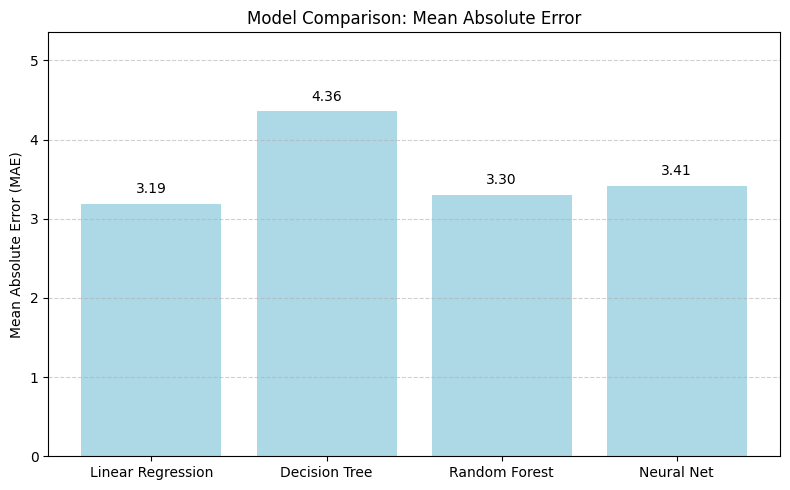

In [ ]:
#Accuracy comparison graph

model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Neural Net']
mae_values = [mae_LR, mae_DC, mae_RF, mae_NN]

#Plot
mtpl.figure(figsize=(8, 5))
bars = mtpl.bar(model_names, mae_values, color='lightblue')

#Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    mtpl.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom')

mtpl.title('Model Comparison: Mean Absolute Error')
mtpl.ylabel('Mean Absolute Error (MAE)')
mtpl.ylim(0, max(mae_values) + 1)
mtpl.grid(axis='y', linestyle='--', alpha=0.6)
mtpl.tight_layout()
mtpl.show()

The bar chart above visualizes the MAE for each model. From the graph, we can clearly see that Linear Regression performed best, achieving the lowest MAE of 3.19, followed closely by Neural Network and Random Forest, both around 3.27–3.30. The Decision Tree model had the highest MAE at 4.36, indicating it was the least accurate in this case. Overall, this visual summary concludes that simpler models like Linear Regression can be surprisingly strong, especially when we selected the right features and preprocessing steps.


To gain a deeper understanding of how well each model explains the variance in driver finishing positions, we also compared their R² scores. The R² score indicates how much of the variability in the outcome variable (finishing position) can be explained by the input features used in the model. An R² of 1 means perfect prediction, while a score of 0 means the model does no better than simply guessing the average. Negative values indicate the model performs worse than the average baseline.







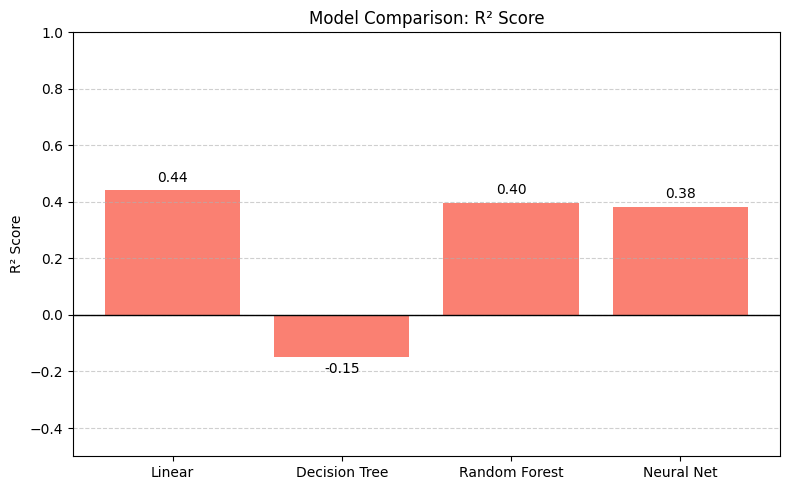

In [ ]:
model_names = ['Linear', 'Decision Tree', 'Random Forest', 'Neural Net']
r2_scores = [r2_LR, r2_DC, r2_RF, r2_NN]

#Determine dynamic y-limits to center 0
min_r2 = min(r2_scores)
max_r2 = max(r2_scores)
margin = 0.1
ymin = min(-.5, min_r2 - margin)
ymax = max(1, max_r2 + margin)

#Plot
mtpl.figure(figsize=(8, 5))
bars = mtpl.bar(model_names, r2_scores, color='salmon')

#Draw horizontal line at zero
mtpl.axhline(0, color='black', linewidth=1)

#Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    offset = 0.02 if yval >= 0 else -0.02
    mtpl.text(bar.get_x() + bar.get_width()/2, yval + offset, f'{yval:.2f}', ha='center', va='bottom' if yval >= 0 else 'top')

mtpl.title('Model Comparison: R² Score')
mtpl.ylabel('R² Score')
mtpl.ylim(ymin, ymax)
mtpl.grid(axis='y', linestyle='--', alpha=0.6)
mtpl.tight_layout()
mtpl.show()

The bar chart above shows the R² performance of each model. Once again, Linear Regression led the way with the highest R² score of 0.44, followed closely by the Neural Network at 0.42 and Random Forest at 0.40. However, Decision Tree performed significantly worse, producing a negative R² score of -0.15, meaning its predictions were worse than simply using the mean.




# **Conclusion**

Throughout this project, we walked through the complete data science pipeline—from data cleaning and exploration to model training and evaluation—with the goal of predicting Formula 1 drivers’ finishing positions based on factors like qualifying results, driver history, team affiliation, and race location. By testing four different regression models—Linear Regression, Decision Tree, Random Forest, and a Neural Network—we were able to compare their performance and draw meaningful conclusions from the results.

Our analysis revealed that qualifying position and recent driver performance (as captured by average finish in the last five races) play a significant role in determining race outcomes. Additionally, our statistical tests supported the idea that starting in pole position gives a driver a measurable advantage. Among the models tested, Linear Regression and the Neural Network achieved the best results, both in terms of Mean Absolute Error and R² score, suggesting that even relatively simple models can offer strong predictive power in this domain when well-engineered features are used. Meanwhile, the Decision Tree Regressor, despite its interpretability, underperformed due to likely overfitting and a lack of generalization.




# **Going Forward**

For an uninformed reader, we hope this project has provided a clear and structured overview of how machine learning can be applied to a real-world problem in motorsport, particularly Formula 1. For those already familiar with the sport or data science, this project offers deeper insights into the kinds of features that matter most in predictive modeling and the relative strengths of various algorithms.

In future work, we could improve our models by including more advanced features, such as weather conditions or tire strategies, and by optimizing hyperparameters for each model. We could also expand the dataset to include more recent seasons or simulate scenarios for new drivers to see how their introduction impacts the performance of others.

Overall, this study highlights how data-driven approaches can help us better understand competitive outcomes in high-performance sports and the importance of model selection, feature engineering, and validation in predictive analytics.

# **References**

Our project makes use of multiple datasets related to Formula 1 race history, driver and constructor performance, qualifying sessions, and lap-by-lap timing. The following sources were used:

Kaggle Dataset – Formula 1 World Championship (1950–2020)
https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
This dataset contains historical F1 data including drivers, races, results, pit stops, and more from 1950 through 2020.

GitHub Repository – Formula 1 Datasets (Extended)
https://github.com/toUpperCase78/formula1-datasets
This source offers extended and sometimes cleaned versions of Kaggle’s original files, updated with modern race seasons and corrected formatting.

OpenF1 – Real-time and Historical F1 Data API
https://openf1.org/
OpenF1 provides comprehensive real-time telemetry and event data, which complements older datasets with more recent details like driver lap times and live race events.